# Modelling natural gas futures prices with RNNs/LSTMs
*by Kenneth Li* 

In [34]:
import math
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf


np.random.seed(1) #Set seed for reproduction

In [35]:
#Import the data with a datetime index
data = pd.read_csv("6-month_Futures_2016-2017_open.csv")
#NOTE:
# I got this data from Quandl with a free account. You can simply sub this data with any time series data you want, like stock price of Alphabet.

data.index = pd.to_datetime(data['Date'])
data.drop('Date',axis=1,inplace=True)
data.sort_index(inplace=True)
print(data.shape)
data.head()

(273, 1)


,Open
Date,
2016-05-02,3.000
2016-05-03,2.959
2016-05-04,2.967
2016-05-05,2.984
2016-05-06,2.996


We can see that the data plotted below doesnt look very periodic at all, and can pose a challenge.

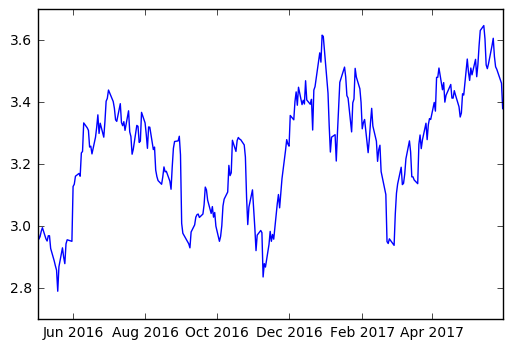

In [36]:
plt.plot(data)
plt.show()

In [37]:
#Configure and reshape data into numpy
dataset = data.values.astype('float32')
#dataset = np.diff(dataset,axis=0)
#Scale to 0-1 scale since LSTM is sensitive
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

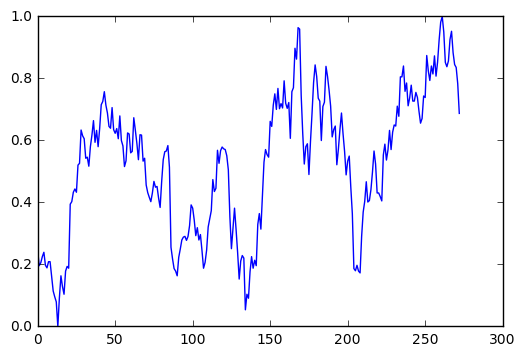

In [38]:
plt.plot(dataset)
plt.show()

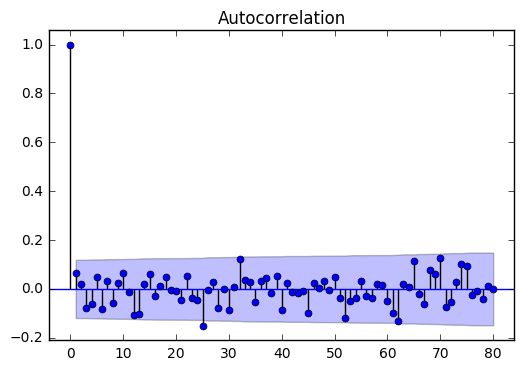

In [32]:
# Autocorrelation plot (default lags is length of dataset)
acf = plot_acf(dataset,lags=80)

In [39]:
#split into train/test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

182 91


In [46]:
def calcRMSE(prediction, results):
    return math.sqrt(mean_squared_error(results, prediction[:,0]))

def calcBIC(prediction, results):
    resid = results - prediction
    sse = np.sum(resid**2)
    k = 1 #num of variables
    n = len(prediction) #num of observations
    BIC = n*np.log(sse/n) + k*np.log(n)
    return BIC
    
def plotResults(dataset, look_back,trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.xlabel("Time steps")
    plt.ylabel("Price")
    plt.show()
    
# convert an array of values into a dataset matrix
# this function is essentially borrowed directly from this great RNN tutorial: 
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def makeModel(dataset, train, test, look_back):
    # reshape into X=t and Y=t+look_back
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features] as per Keras Sequential documentation
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(None,look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=10, verbose=0) # You can toggle verbose to 0 if you dont want to see output
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions back to original scale
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY.reshape(-1,1))
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY.reshape(-1,1))

    # calculate root mean squared error
    print('Train Score: %.2f RMSE' % (calcRMSE(trainY,trainPredict)))
    print('Test Score: %.2f RMSE' % (calcRMSE(testY,testPredict)))
    
    # calculate BIC
    bic = calcBIC(trainY,trainPredict)
    print('BIC: %.2f ' % bic)
    
    #Plot results
    plotResults(dataset, look_back, trainPredict, testPredict)
    
    return model, bic

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE
BIC: -1039.06 


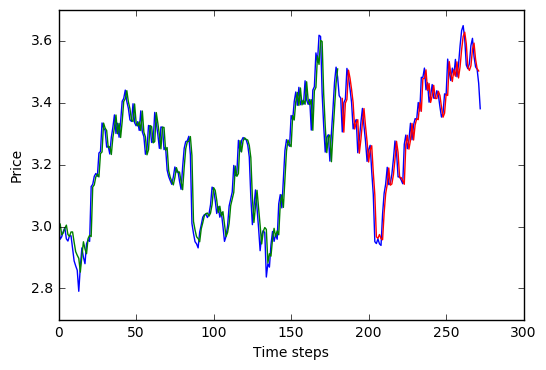

Train Score: 0.06 RMSE
Test Score: 0.06 RMSE
BIC: -984.87 


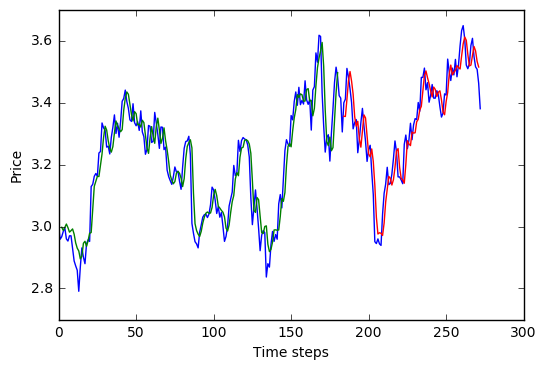

In [58]:
bic_all = []
for x in range(1,3):
    model, bic = makeModel(dataset, train, test, x)
    bic_all.append(bic)

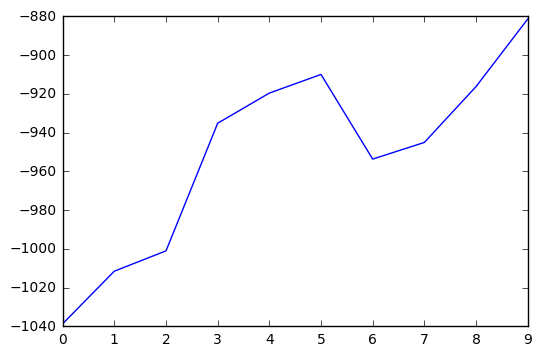

In [79]:
#plot bic 
plt.plot(bic_all)

## Forecasting 

If we want the model to predict prices a few time steps into the future, we can have it 'generate' its time series by continually predicting the next value, starting from the last value in the dataset. (this part is not from the tutorial)

Train Score: 0.06 RMSE
Test Score: 0.05 RMSE
BIC: -1036.78 


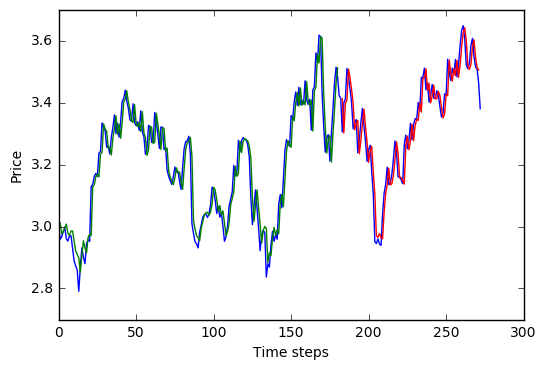

In [53]:
# Make our model again to make sure we use the params we want
look_back = 1
model, bic = makeModel(dataset, train, test, look_back)

In [54]:
# Create an array specified to the appropriate input dimensions. (In this case, it's 50 samples, 1 other time step, and 1 feature, which is the price)

def createForecast(start_point, forward_steps):
    forecastX = np.empty((forward_steps, 1, 1))
    #Insert last value of dataset (which is scaled)
    forecastX[0,0] = dataset[start_point]

    # Loop, predict, and populate the array
    for x in range(forward_steps-1):
        feed = np.reshape(forecastX[x],(1,1,1))
        forecastX[x+1,0] = model.predict(feed)[0]
    
    forecastX = scaler.inverse_transform(forecastX[:,0])
    return forecastX

As we see below, forecasting with this method doesn't work well with an RNN because it feeds itself its own predictions, which defeats the idea of a 'time series', despite being already trained. Without a real history to make predictions on, the model makes some forecasts and levels off. 

Next steps would include incorporating additional factors like seasonality, weather data, and storage levels that can help the RNN make price predictions with context outside of a single time series. 

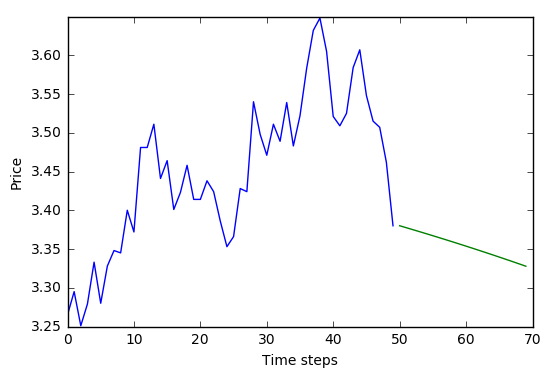

In [55]:
#Set how far back in dataset points we want to see
past_data = 50
forward_steps = 20 

forecastX = createForecast(-1,forward_steps)
#Shift forecast and plot
forecastPlot = np.empty((past_data+forward_steps,1))
forecastPlot[:, :] = np.nan
forecastPlot[past_data:, :] = forecastX
# plot last x points of baseline and forecast
plt.plot(scaler.inverse_transform(dataset[-past_data:]))
plt.plot(forecastPlot)
plt.xlabel("Time steps")
plt.ylabel("Price")
plt.show()

## Multiple Forecasts

Lets test this method of forecasting against our training data to see if it produces any insight into the direction of price movement.

In [56]:
# Plot all the forecasts
def plotForecast(start_point,forecastX,look_back):
    #Shift forecast by its starting point
    forecastPlot = np.empty((len(dataset)+forward_steps+look_back,1))
    forecastPlot[:, :] = np.nan
    forecastPlot[start_point:start_point+forward_steps, :] = forecastX
    return forecastPlot

Just edit the params `starts` and `forward_steps` below to play around with this.

With an example of 5 starts and 20 forward steps, we can see that the trend predicted by the RNN yields some predictive power. The futures prices seem to follow the middle three forecasts during their prediction period, while the first and last forecasts are only accurate at arbitrarily long number time steps. 

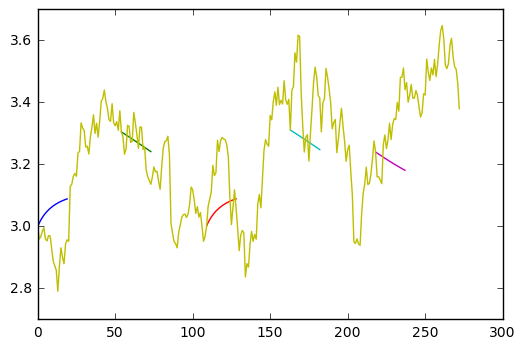

In [57]:
# Pick x different starting points along dataset for forecast 
starts = 5
forward_steps = 20

startpoints=[]
for x in range(0,starts):
    startpoints.append(int((1/starts)*x*len(dataset)))

forecasts = []
# Append forecast data into a list
for x in range(starts):
    forecasts.append(createForecast(startpoints[x],forward_steps))
    
# PLot all forecasts
for x in range(len(forecasts)):
    plt.plot(plotForecast(startpoints[x],forecasts[x],look_back))

plt.plot(scaler.inverse_transform(dataset))
plt.show()